<a href="https://colab.research.google.com/github/chrisart10/PuzzleAI/blob/main/pipeline3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definir dimension de imagen

In [1]:
input_shape =300

# Importar modelos mediante tranfer learning

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (input_shape, input_shape, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-02-12 19:19:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   290MB/s    in 0.3s    

2021-02-12 19:19:22 (290 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 17, 17, 768)


# Ultima capa de aprendizaje

In [4]:
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (6, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

## Rocket science


In [5]:
#model.summary()

# Importar Dataset desde kaggle

In [6]:
! pip install -q kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chrisart10","key":"a4d7a5ccdb579a3da96cba78228ec9c6"}'}

In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Pegar Api del dataset

In [9]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.57G/3.58G [01:05<00:00, 45.5MB/s]
100% 3.58G/3.58G [01:05<00:00, 58.6MB/s]


In [ ]:
#!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:49<00:00, 36.5MB/s]
100% 5.20G/5.20G [01:49<00:00, 50.8MB/s]


# Extraer zip

In [10]:
import os
import zipfile

#local_zip = '/content/skin-cancer-mnist-ham10000.zip'
local_zip = "/content/fruits-fresh-and-rotten-for-classification.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Preparar Dataset y asignar data augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define our example directories and files
base_dir = '/tmp/dataset/'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'test')

# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (input_shape, input_shape))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (input_shape, input_shape))

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


# callback con early stopping


In [12]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') >= 0.98):
                print("\nReached 98% accuracy so cancelling training!")
                self.model.stop_training = True
callbacks = myCallback()

# Entrenar el modelo

In [13]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 32,
            epochs = 100,
            callbacks=[callbacks],
            validation_steps = 32,
            verbose = 1)

Epoch 1/100
32/32 [==============================] - 28s 580ms/step - loss: 2.5920 - accuracy: 0.4076 - val_loss: 0.4284 - val_accuracy: 0.8469
Epoch 2/100
32/32 [==============================] - 18s 561ms/step - loss: 0.4661 - accuracy: 0.8251 - val_loss: 0.2546 - val_accuracy: 0.9047
Epoch 3/100
32/32 [==============================] - 18s 558ms/step - loss: 0.4498 - accuracy: 0.8402 - val_loss: 0.2065 - val_accuracy: 0.9375
Epoch 4/100
32/32 [==============================] - 18s 563ms/step - loss: 0.2827 - accuracy: 0.9074 - val_loss: 0.1710 - val_accuracy: 0.9500
Epoch 5/100
32/32 [==============================] - 18s 563ms/step - loss: 0.2748 - accuracy: 0.9185 - val_loss: 0.0917 - val_accuracy: 0.9672
Epoch 6/100
32/32 [==============================] - 18s 575ms/step - loss: 0.1707 - accuracy: 0.9463 - val_loss: 0.0741 - val_accuracy: 0.9766
Epoch 7/100
32/32 [==============================] - 18s 567ms/step - loss: 0.2256 - accuracy: 0.9358 - val_loss: 0.1114 - val_accuracy:

# visualizacion del aprendizaje

<Figure size 432x288 with 0 Axes>

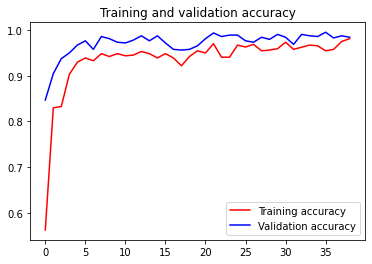

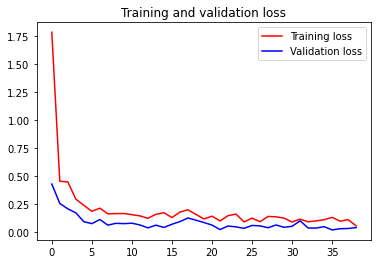

<Figure size 432x288 with 0 Axes>

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, 'r', label='Training loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss'   )
plt.legend(loc=0)
plt.figure()

# Test del modelo 

In [19]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(input_shape, input_shape))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(classes[0])
  # if classes[0]>0.5:
  #   print(fn + " is a dog")
  # else:
  #   print(fn + " is a cat")

Saving 38345-0w470h470_Organic_Navelate_Oranges.jpg to 38345-0w470h470_Organic_Navelate_Oranges.jpg
[0. 1. 0. 0. 0. 0.]


# forma de guardar Opcion 1

In [ ]:
import time
path = '/tmp/simple_keras_model'
model.save(saved_model_path)

In [ ]:
new_model = tf.keras.models.load_model('/tmp/saved_models/1612553978/')

# Check its architecture
#new_model.summary()


NameError: ignored

# Forma de guardar opcion 2

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('/tmp/saved_models/versions/my_model1.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/tmp/saved_models/versions/my_model1.h5')

# Show the model architecture
#new_model.summary()

NameError: ignored